In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [5]:
# Basic Bandit where N(u, v), u ~ U(0,10), V ~ U(1,2)

class Bandit:
    def __init__(self, n_arms):
        self.means = np.random.uniform(0, 10, size = n_arms)
        self.vars = np.random.uniform(1,2, size = n_arms)
    
    def pull(self, i):
        loc = self.means[i]
        scale = self.vars[i]
        return np.random.normal(loc, scale)

In [6]:
class Agent:
    def __init__(self):
        self.rewards = []
        self.choices = []
    
    def update(self, choice, reward):
        pass
    
    def select(self):
        pass

class EpsilonAgent(Agent):
    def __init__(self, n_arms, epsilon):
        super().__init__()
        self.epsilon = epsilon
        self.means = np.zeros(n_arms)
        self.count = np.zeros(n_arms)
    
    def update(self, choice, reward):
        n = self.count[choice]
        self.means[choice] =(n * self.means[choice] + reward) / (n + 1)
        self.count[choice] += 1
        self.rewards.append(reward)
    
    def select(self):
        if np.random.rand() > self.epsilon:
            choice = np.argmax(self.means)
        else:
            choice = np.random.choice(len(self.means))
        self.choices.append(choice)
        return choice

class SoftmaxAgent(Agent):
    def __init__(self, n_arms, temp):
        super().__init__()
        self.temp = temp
        self.means = np.zeros(n_arms)
        self.count = np.zeros(n_arms)
    
    def update(self, choice, reward):
        n = self.count[choice]
        self.means[choice] = (n * self.means[choice] + reward) / (n + 1)
        self.count[choice] += 1
        self.rewards.append(reward)
    
    def select(self):
        probs = np.exp(self.means / self.temp) / sum(np.exp(self.means / self.temp))
        choice = np.random.choice(len(self.means), p = probs)
        self.choices.append(choice)
        return choice

class SoftmaxDecayAgent(Agent):
    def __init__(self, n_arms, temp, temp_decay = 0.99):
        super().__init__()
        self.temp = temp
        self.temp_decay = temp_decay
        self.means = np.zeros(n_arms)
        self.count = np.zeros(n_arms)
    
    def update(self, choice, reward):
        n = self.count[choice]
        self.means[choice] = (n * self.means[choice] + reward) / (n + 1)
        self.count[choice] += 1
        self.rewards.append(reward)
        self.temp = np.power(self.temp, self.temp_decay)
    
    def select(self):
        probs = np.exp(self.means / self.temp) / sum(np.exp(self.means / self.temp))
        choice = np.random.choice(len(self.means), p = probs)
        self.choices.append(choice)
        return choice

class BayesianAgent(Agent):
    def __init__(self, n_arms, epsilon, u0 = 5.):
        super().__init__()
        self.epsilon = epsilon
        self.means = np.full(n_arms, u0, dtype = np.float32)
        self.vars = np.ones(n_arms) * 10
    
    def update(self, choice, reward, v = 1):
        cur_mean = self.means[choice]
        cur_var = self.vars[choice]
        # Bayesian update rule.
        self.means[choice] = (v * cur_mean + cur_var * reward) / (cur_var + v)
        self.vars[choice] = (v * cur_var) / (cur_var + v)
        self.rewards.append(reward)
    
    def select(self):
        if np.random.rand() > self.epsilon:
            choice = np.argmax(self.means)
        else:
            choice = np.random.choice(len(self.means))
        self.choices.append(choice)
        return choice

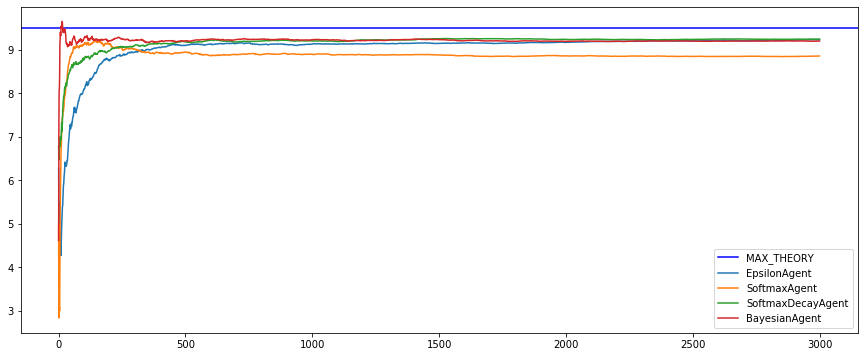

In [7]:
np.random.seed(42)

n_arms = 3
epsilon = 0.1
iterations = 3000
temp = 2
bandit = Bandit(n_arms)
agents = [
    EpsilonAgent(n_arms, epsilon),
    SoftmaxAgent(n_arms, temp),
    SoftmaxDecayAgent(n_arms, temp),
    BayesianAgent(n_arms, epsilon)
]

for i in range(iterations):
    for agent in agents:
        choice = agent.select()
        reward =  bandit.pull(choice)
        agent.update(choice, reward)

plt.figure(figsize=(15,6))

ax1 = plt.subplot(111)
ax1.axhline(max(bandit.means), c = 'b')
for i, agent in enumerate(agents):
    rewards = agent.rewards
    cum_reward_mean = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
    ax1.plot(np.arange(iterations), cum_reward_mean)
ax1.legend(['MAX_THEORY'] + [x.__class__.__name__ for x in agents])

plt.show()

In [8]:
import torch
from torch.nn import Module, Linear, MSELoss
import torch.nn.functional as F

In [9]:
class ContextualBandit:
    def __init__(self, n_arms, states):
        self.bandits = [Bandit(n_arms) for _ in range(n_states)]
        self.n_states = states
        self.cur_state = 0
    
    def get_state(self):
        return self.cur_state
    
    def update_state(self):
        self.cur_state = np.random.randint(self.n_states)
    
    def pull(self, i):
        return self.bandits[self.cur_state].pull(i)

class TextbookNeuralAgent(Module):
    # The textbook neural network doesn't make any sense
    def __init__(self, n_arms, n_states):
        super().__init__()
        self.l1 = Linear(n_states, 100)
        self.l2 = Linear(100, n_arms)
    
    def forward(self, x):
        a1 = F.relu(self.l1(x))
        a2 = F.relu(self.l2(a1))
        return a2

class NeuralAgent(Module):
    def __init__(self, n_arms, n_states):
        super().__init__()
        self.n_arms = n_arms
        self.n_states = n_states
        self.l1 = Linear(n_states + n_arms, 100)
        self.l2 = Linear(100, 1)
    
    def select(self, state, debug = False):
        means = []
        for i in range(n_arms):
            inp = torch.zeros(self.n_states + self.n_arms)
            inp[state] = 1
            inp[self.n_states + i] = 1
            means.append(self.forward(inp))
        if debug: print(torch.Tensor([float(x) for x in means]))
        p_num = F.softmax(torch.Tensor([float(x) for x in means]), dim = 0).detach().numpy()
        p_num /= sum(p_num)
        choice = np.random.choice(self.n_arms, p = p_num)
        return choice, means[choice]
    
    def forward(self, x):
        a1 = F.relu(self.l1(x))
        a2 = F.relu(self.l2(a1))
        return a2

In [11]:
def ohe(i, d, a = 1):
    z = np.zeros(d)
    z[i] = a
    return z

In [12]:
n_arms = 10
n_states = 10
iterations = 7000

learning_rate = 0.03
bandit = ContextualBandit(n_arms, n_states)
model = NeuralAgent(n_arms, n_states)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = MSELoss()


rewards = []
for i in range(iterations):
    state = bandit.get_state()
    choice, pred = model.select(state)
    reward = bandit.pull(choice)
    reward_vec = ohe(0, 1, a = reward)
    loss = loss_fn(pred, reward_vec)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    bandit.update_state()
    rewards.append(reward)

cum_reward_mean = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
theory_max = np.mean(np.array([b.means for b in  bandit.bandits]).max(axis = 1))
plt.axhline(theory_max, c = 'r')
plt.plot(cum_reward_mean)
plt.show()

TypeError: 'int' object is not callable

In [ ]:
rewards = []
test_iterations = 1000
for i in range(test_iterations):
    state = bandit.get_state()
    choice, pred = model.select(state)
    reward = bandit.pull(choice)
    bandit.update_state()
    rewards.append(reward)

In [ ]:
cum_reward_mean = np.cumsum(rewards) / np.arange(1, len(rewards) + 1)
theory_max = np.mean(np.array([b.means for b in  bandit.bandits]).max(axis = 1))
plt.axhline(theory_max, c = 'r')
plt.plot(cum_reward_mean)
plt.show()